Testje

# DGM Lab 3 - Variational Autoencoders

In this Lab, we will build and train latent variable models using the Variational Autoencoder framework.

 ## Variational Autoencoders

 A variational autoencoder consists of a likelihood model, or decoder $p_\theta(x| z)$, and an approximate posterior model, or encoder $q(z | x)$.

 ### Assignment 1

 We will build a Variational Autoencoder for modelling MNIST digits. As you recall from Lab 1, MNIST digits are 28x28 binary images of handwritten digits. Build an `Encoder` and `Decoder` class as Pytorch `nn.Module`s, which represent $q(z | x)$ and $p_\theta(x| z)$. Parameterize the latent space $z$ as a multivariate Gaussian with diagonal covariance matrix. A simple architecture will suffice, for example a 2 hidden layer fully connected neural network. For now, limit the latent space to two dimensions, so we can visualize and investigate the learnt manifold later.

 Think how to parameterize the outputs of each model. For example, a Gaussian can be parameterized by means and standard deviations, or means and variance, or mean and log variance, ... Similarly the likelihood model should model a distribution over pixels. Which distribution seems appropriate for binary pixels?

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(torch.nn.Module):
    def __init__(self, input_dim:int=784, hidden_dim:int=512, latent_dim:int=2):
        super(Encoder, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)

        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar = torch.nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim:int=2, hidden_dim:int=512, output_dim:int=784):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.fc1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h))

To test your classes, load the MNIST dataset, and forward a batch of data through the `Encoder`. Similarly, create a batch of $z$ tensors, forward these through the `Decoder` and plot the results.

torch.Size([16, 1, 28, 28])
torch.Size([16, 2]) torch.Size([16, 2])
torch.Size([16, 784])
torch.Size([16, 28, 28])


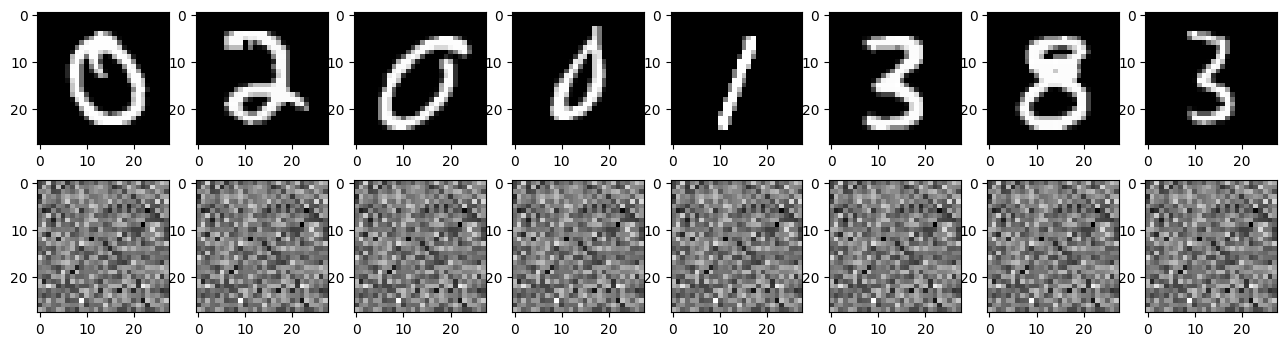

In [ ]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=16, shuffle=True)

# sample a batch
sample_batch, _ = next(iter(data_loader))

encoder = Encoder()
decoder = Decoder()

print(sample_batch.shape)
mu, logvar = encoder(sample_batch.reshape(-1, 784))

print(mu.shape, logvar.shape)

std = torch.exp(0.5*logvar)
z = mu + std

decoded = decoder(z)
print(decoded.shape)

# reshape to -1, 28, 28
decoded = decoded.view(-1, 28, 28)

print(decoded.shape)

# plot the images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    ax[0, i].imshow(sample_batch[i].view(28, 28), cmap='gray')
    ax[1, i].imshow(decoded[i].detach().numpy(), cmap='gray')

To train the Variational Autoencoder end-to-end with stochastic gradient descent, we need to sample from the posterior distribution in a differentiable way. Implement a `sample()` method that recieves as argument (a batch of) parameters of the posterior distribution, and returns (a batch of) samples using the reparameterization trick.

In [ ]:
def sample(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

Now test the whole forward pass: fetch a batch of MNIST images, get the approximate posterior distribution, sample a latent code from this distribution, and reconstruct images using the likelihood model.

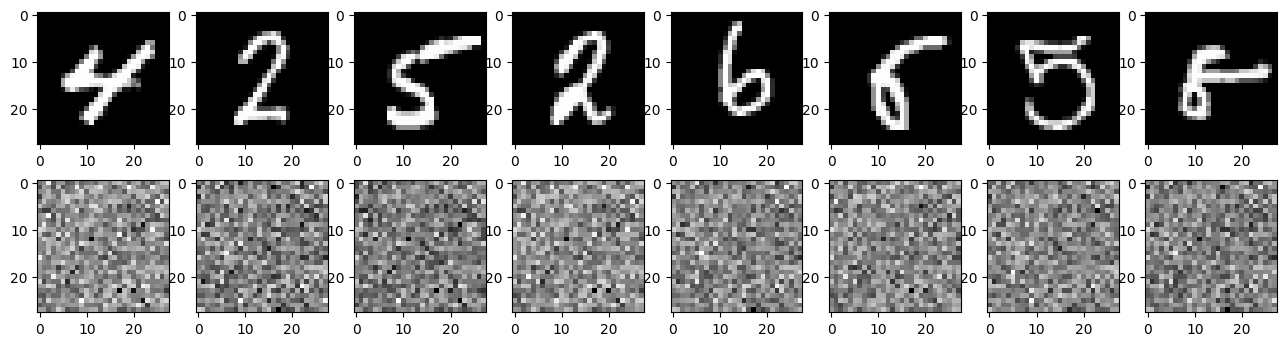

In [ ]:
sample_batch, _ = next(iter(data_loader))
sample_batch = sample_batch.reshape(-1, 784)

mu, logvar = encoder(sample_batch)
z = sample(mu, logvar)
decoded = decoder(z)

decoded = decoded.view(-1, 28, 28)

fig, ax = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    ax[0, i].imshow(sample_batch[i].view(28, 28), cmap='gray')
    ax[1, i].imshow(decoded[i].detach().numpy(), cmap='gray')

### Assignment 2

Before we can write the train loop, we need to implement the loss function. Variational autoencoders are trained by maximizing the Evidence Lower Bound (ELBO). Define the function `elbo_loss()` that calculates the loss, given a batch of images, latent distributions and reconstructions. The exact implementation will depend on the parameterization of your posterior and likelihood model. Note that if all pixels are modelled as independent, the correct, total log likelihood should be the summation of each term attributed to each pixel.

In [ ]:
import torch.nn.functional as F

def elbo_loss(x, mu, logvar, decoded, beta: float = 1.0):
    recon_loss = torch.nn.functional.binary_cross_entropy(decoded, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div


Now implement the train loop and train both the `Encoder` and `Decoder` jointly. After a few epochs you should already see sensible reconstructions.

In [ ]:
def latent_space_grid():
    n = 9
    x = torch.linspace(-3, 3, n)

    xv, yv = torch.meshgrid(x, x)
    z = torch.stack([xv, yv], dim=-1).view(-1, 2)

    z = z.to(device)

    decoded = decoder(z)
    decoded = decoded.view(-1, 28, 28).cpu()

    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n*n):
        ax[i//n, i%n].imshow(decoded[i].detach().numpy(), cmap='gray')
        ax[i//n, i%n].axis('off')

    # don't show the fig only return it
    return fig

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def train(encoder: torch.nn.Module, decoder: torch.nn.Module, data_loader: torch.utils.data.DataLoader, epochs: int = 100, lr: float = 1e-3, beta: float = 1.0, run_title: str = None):
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    run_title = f"vae_mnist_{run_title or ''}_beta_{beta}_lr_{lr}"

    writer = SummaryWriter(log_dir=f'./runs/{run_title}')

    samples = train_set.data[:10].float().numpy() / 255
    samples_tensor = torch.tensor(samples).to(device)

    for i in range(10):
        writer.add_image(f'Original_{i}', samples[i], 0, dataformats='HW')

    for epoch in range(epochs):
        encoder.train()
        decoder.train()

        train_loss = 0
        for i, x in enumerate(data_loader):
            x = x[0].to(device).reshape(-1, 784)
            optimizer.zero_grad()

            mu, logvar = encoder(x)
            z = sample(mu, logvar)
            decoded = decoder(z)

            loss = elbo_loss(x, mu, logvar, decoded)

            loss.backward()
            train_loss += loss.item()

            optimizer.step()

            writer.add_scalar('Loss/train', loss.item(), epoch * len(data_loader) + i)

        print('Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(data_loader.dataset)))
        # reconstruct from the samples and show in tensorboard
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            mu, logvar = encoder(samples_tensor.view(-1, 784))
            z = sample(mu, logvar)
            decoded = decoder(z)
            decoded = decoded.view(-1, 28, 28)
            for i in range(10):
                writer.add_image(f'Reconstructed_{i}', decoded[i].cpu().detach().numpy(), epoch, dataformats='HW')

        if decoder.latent_dim == 2:
            fig = latent_space_grid()
            writer.add_figure('Latent Space', fig, global_step=epoch)

    writer.flush()
    writer.close()

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=8192, shuffle=True)

encoder = Encoder(hidden_dim=512, latent_dim=2)
decoder = Decoder(hidden_dim=512, latent_dim=2)

encoder.to(device)
decoder.to(device)

train(encoder, decoder, data_loader, epochs=100, lr=1e-3, beta=1.0, run_title='hd_512_latent_2')



Epoch: 0 Average loss: 406.2880


KeyboardInterrupt: 

Let's take a closer look at what the model has learnt. In theory, the likelihood model should have learnt a 2D Gaussian latent manifold for all MNIST digits. To visualize this manifold, sample latent codes on a grid centered around (0,0), and visualize the outputs of the likelihood model.

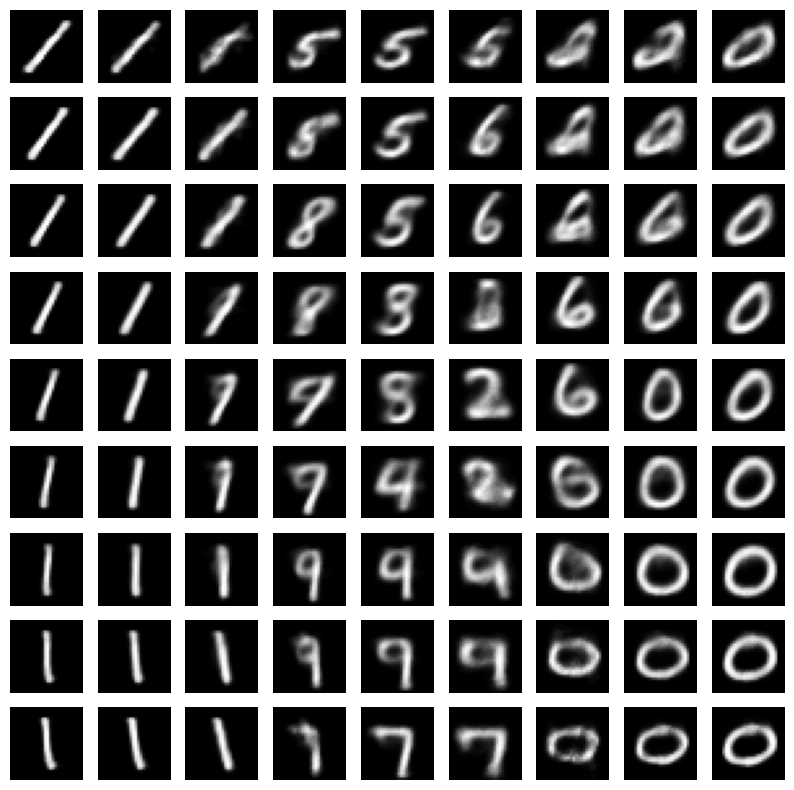

In [ ]:
latent_space_grid();

Similarly, we can also encode all MNIST digits from the test set using the approximate posterior model, and plot the means of the resulting posterior distributions on a scatter plot. Use the MNIST digit label as the color for each data point.

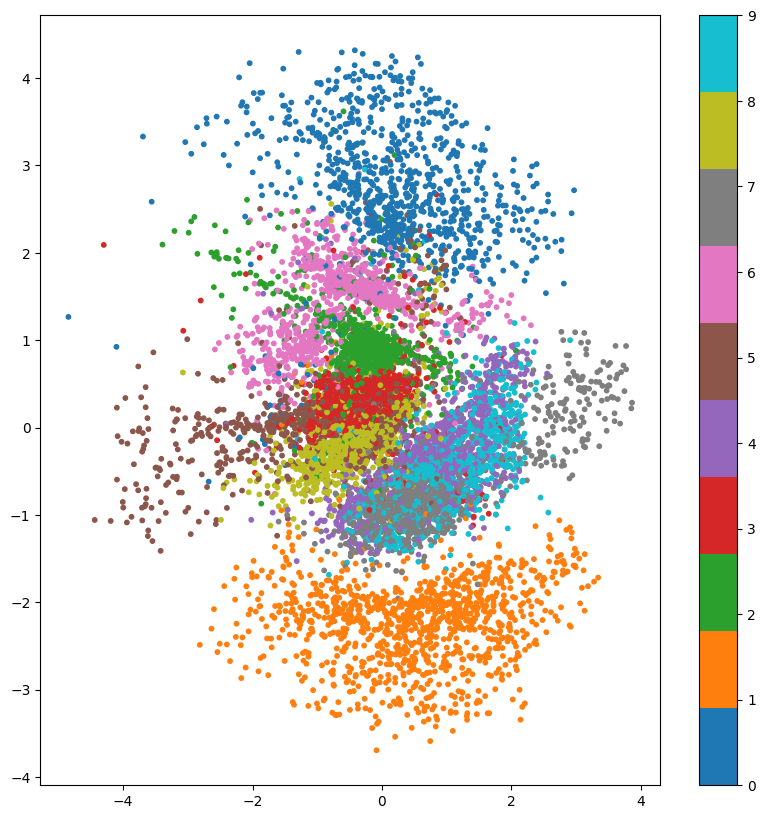

In [ ]:
import numpy as np

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=100, shuffle=True)

encoder.eval()
decoder.eval()

z_enc = []
labels = []

for x, y in test_loader:
    x = x.to(device).reshape(-1, 784)
    mu, logvar = encoder(x)
    z = mu
    z_enc.append(z.cpu().detach().numpy())
    labels.append(y.numpy())

z_enc = np.concatenate(z_enc)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 10))
plt.scatter(z_enc[:, 0], z_enc[:, 1], c=labels, cmap='tab10', marker='o', s=10)
plt.colorbar()
plt.show()

## The information bottleneck and $\beta$-VAE

The dimensionality of the latent code, as well as the KL term in the ELBO loss regulate the information bottleneck of the Variational Autoencoder. The $\beta$-VAE lets you explicitly tune the pressure of this bottleneck via the loss function.

### Assignment 3

Instantiate a new `Encoder` and `Decoder`, now with a larger latent dimensionality (e.g. 10 latent dimensions). Re-train such a VAE. To get an intuition on what the different latent dimensions encode, create again a grid in which you vary a single latent dimension (e.g. -3 .. 3) in each row. Also increase the capacity of the encoder and decoder by increasing the size of the hidden layers.

In [ ]:
# TODO: do more experiments and write down results and compare
# Runs are stored using tensorboard so comparison can be done easier. Give good titles to runs

encoder = Encoder(hidden_dim=1024, latent_dim=10).to(device)
decoder = Decoder(hidden_dim=1024, latent_dim=10).to(device)

train(encoder, decoder, data_loader, epochs=100, lr=1e-3, beta=1.0, run_title='hd_1024_latent_10')

Epoch: 0 Average loss: 352.2288
Epoch: 1 Average loss: 222.1360
Epoch: 2 Average loss: 215.2541
Epoch: 3 Average loss: 210.5995
Epoch: 4 Average loss: 206.6776
Epoch: 5 Average loss: 202.9461
Epoch: 6 Average loss: 200.0433
Epoch: 7 Average loss: 197.5154
Epoch: 8 Average loss: 195.5825
Epoch: 9 Average loss: 193.8949
Epoch: 10 Average loss: 192.4170
Epoch: 11 Average loss: 191.1917
Epoch: 12 Average loss: 189.7444
Epoch: 13 Average loss: 187.7527
Epoch: 14 Average loss: 184.7799
Epoch: 15 Average loss: 181.5879
Epoch: 16 Average loss: 178.2230
Epoch: 17 Average loss: 175.2813
Epoch: 18 Average loss: 172.5617
Epoch: 19 Average loss: 168.6728
Epoch: 20 Average loss: 164.6444
Epoch: 21 Average loss: 161.5507
Epoch: 22 Average loss: 158.9954
Epoch: 23 Average loss: 156.2106
Epoch: 24 Average loss: 153.3586
Epoch: 25 Average loss: 150.7315
Epoch: 26 Average loss: 148.6308
Epoch: 27 Average loss: 146.7579
Epoch: 28 Average loss: 145.0217
Epoch: 29 Average loss: 143.2688
Epoch: 30 Average lo

Now change the loss function to add a $\beta$ factor for the KL term. Visualize again the reconstructions and experiment with different $\beta$ values. What is the effect of a higher / lower $\beta$. Can you explain this?

In [ ]:
encoder = Encoder(hidden_dim=1024, latent_dim=10).to(device)
decoder = Decoder(hidden_dim=1024, latent_dim=10).to(device)

train(encoder, decoder, data_loader, epochs=100, lr=1e-3, beta=1.5, run_title='hd_1024_latent_10')

Epoch: 0 Average loss: 353.2420
Epoch: 1 Average loss: 222.4522
Epoch: 2 Average loss: 215.6870
Epoch: 3 Average loss: 211.0625
Epoch: 4 Average loss: 208.0849
Epoch: 5 Average loss: 204.1590
Epoch: 6 Average loss: 201.5280
Epoch: 7 Average loss: 199.4126
Epoch: 8 Average loss: 196.9554
Epoch: 9 Average loss: 194.9410
Epoch: 10 Average loss: 193.3125
Epoch: 11 Average loss: 191.9227
Epoch: 12 Average loss: 190.6122
Epoch: 13 Average loss: 189.3817
Epoch: 14 Average loss: 187.6127
Epoch: 15 Average loss: 184.6641
Epoch: 16 Average loss: 181.3487
Epoch: 17 Average loss: 177.6513
Epoch: 18 Average loss: 174.3753
Epoch: 19 Average loss: 172.2108
Epoch: 20 Average loss: 169.6572
Epoch: 21 Average loss: 167.1020
Epoch: 22 Average loss: 163.5955
Epoch: 23 Average loss: 159.8034
Epoch: 24 Average loss: 155.4428
Epoch: 25 Average loss: 151.9142
Epoch: 26 Average loss: 149.1711
Epoch: 27 Average loss: 147.0514
Epoch: 28 Average loss: 145.6305
Epoch: 29 Average loss: 143.1750
Epoch: 30 Average lo

## Discrete latent spaces

Until now we modelled the latent space as a Gaussian distribution. However, it is clear that at least one factor of variation (i.e. the digit) is inherintly discrete. To address this, we will now use Categorical latent distributions, and apply the reparameterization trick using the Gumbel-Softmax.

### Assignment 4

Create a new `Encoder` and `Decoder`, but now parameterize the latent distribution as a Categorical distribution with $k=10$. Reimplement the sample method to use the Gumbel-Softmax trick for reparameterization, and adjust the loss function (i.e. use a Uniform prior instead of $N(0,1)$). Again, train end-to-end and visualize the resulting latent space. If all goes well you should see that some latent dimensions actually map to a number. However it won't nicely assign each digit class to a latent dimension, due to the unsupervised training and the model capacity. To have better reconstructions, you could try more higher dimensional latent codes, for example 10 Categoricals with each $k=10$, or 100 Bernoulli variables. Another option is to have a mixed discrete and continuous latent space.

## Closing remarks

In this Lab session we've experimented with VAE's on the MNIST dataset. We've used a simple fully connected encoder and decoder architecture. In order to get better results, it might be worthwhile exploring other architectures, in particular convolutional neural networks for encoding and decoding images. You can also easily test this on more compelling datasets that are available in `torchvision`, for example CelebA or others.